# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Mounted at /content/drive
Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [5]:
# ----------------------------
# Load data + create targets
# ----------------------------

CSV_PATH = "/content/drive/MyDrive/Junior Year/EE 344/classData.csv"
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [6]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [7]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [45]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model = DNN_Reg4().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

In [46]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()

    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0  # number of samples

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        # average loss for the epoch
        avg_loss = total / n

        # print epoch info at start, middle, and end
        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep:4d} | Train MSE: {avg_loss:.6f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

train_part1(model, train_loader_1)


Epoch    1 | Train MSE: 0.755766
Epoch  500 | Train MSE: 0.111750
Epoch 1000 | Train MSE: 0.107302


In [47]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.9419    0.7228    0.8179      2377
           C     0.9913    0.9041    0.9457      2263
           B     0.9993    0.8871    0.9399      3057
           A     0.9681    0.9761    0.9721      3144

   micro avg     0.9768    0.8805    0.9261     10841
   macro avg     0.9751    0.8725    0.9189     10841
weighted avg     0.9760    0.8805    0.9237     10841
 samples avg     0.6686    0.6251    0.6412     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[3019  106]
 [ 659 1718]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3221   18]
 [ 217 2046]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2443    2]
 [ 345 2712]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2257  101]
 [  75 3069]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.9347    0.7164    0.8111      1019
           C     0.9864    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

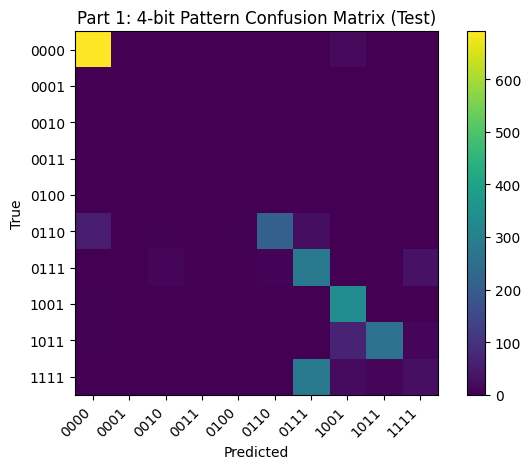

[[691   1   0   0   0   0   0  18   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 55   0   5   0   4 212  25   0   0   0]
 [  1   0   9   0   0   7 279   0   0  33]
 [  3   0   0   0   0   0   0 336   0   0]
 [  3   1   0   0   0   0   0  67 257  12]
 [  1   0   0   1   0   1 279  20  10  28]]


In [48]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [49]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [50]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.1

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        return self.net(x)

In [51]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model = DNN_MultiLabel4()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [52]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            #pass
            n += xb.size(0)

            avg_loss = total / n

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep:4d} | Train BCE: {avg_loss:.6f}")
            #pass

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model, train_loader_2)


Epoch    1 | Train BCE: 0.705063
Epoch  500 | Train BCE: 0.140739
Epoch 1000 | Train BCE: 0.137229


In [17]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.9223    0.7493    0.8268      2377
           C     0.9995    0.9417    0.9697      2263
           B     0.9983    0.9450    0.9709      3057
           A     0.9997    0.9781    0.9887      3144

   micro avg     0.9844    0.9110    0.9462     10841
   macro avg     0.9799    0.9035    0.9391     10841
weighted avg     0.9823    0.9110    0.9443     10841
 samples avg     0.6808    0.6479    0.6602     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2975  150]
 [ 596 1781]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3238    1]
 [ 132 2131]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2440    5]
 [ 168 2889]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2357    1]
 [  69 3075]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.9207    0.7517    0.8277      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

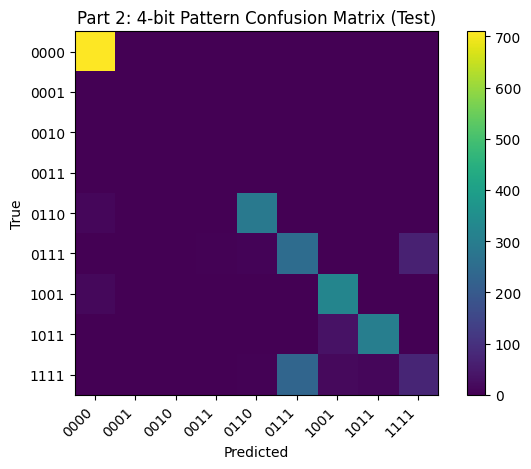

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 13   0   2   0 286   0   0   0   0]
 [  0   0   0   5   8 250   0   0  66]
 [ 15   1   0   0   0   0 323   0   0]
 [  0   0   0   0   0   0  36 304   0]
 [  0   0   0   0   5 232  18  12  73]]


In [18]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [19]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [20]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, num_classes)
        )
        #pass

    def forward(self, x):
        # TODO: forward pass returning logits (N,6)
        return self.net(x)
        #pass


In [21]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...
model = DNN_MultiClass6()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)



In [22]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            #pass
            n += xb.size(0)

            avg_loss = total/n

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep:4d} | Train CE: {avg_loss:.6f}")
            #pass

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model, train_loader_3)


Epoch    1 | Train CE: 10045.205760
Epoch  500 | Train CE: 4.415141
Epoch 1000 | Train CE: 2.206674



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9617    1.0000    0.9805      1655
          LG     0.9152    0.9557    0.9350       790
          LL     0.9147    0.9616    0.9376       703
         LLG     0.9475    0.9547    0.9511       794
         LLL     0.5565    0.4237    0.4811       767
        LLLG     0.5078    0.5334    0.5203       793

    accuracy                         0.8346      5502
   macro avg     0.8006    0.8048    0.8009      5502
weighted avg     0.8250    0.8346    0.8283      5502



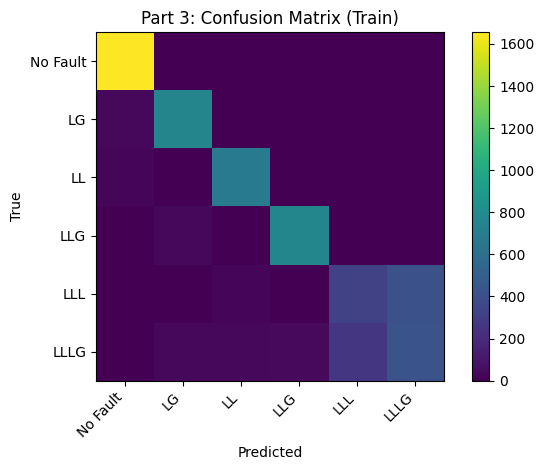


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9608    1.0000    0.9800       710
          LG     0.9195    0.9440    0.9316       339
          LL     0.9151    0.9668    0.9402       301
         LLG     0.9560    0.9588    0.9574       340
         LLL     0.5447    0.4255    0.4778       329
        LLLG     0.5112    0.5353    0.5230       340

    accuracy                         0.8347      2359
   macro avg     0.8012    0.8051    0.8017      2359
weighted avg     0.8255    0.8347    0.8288      2359



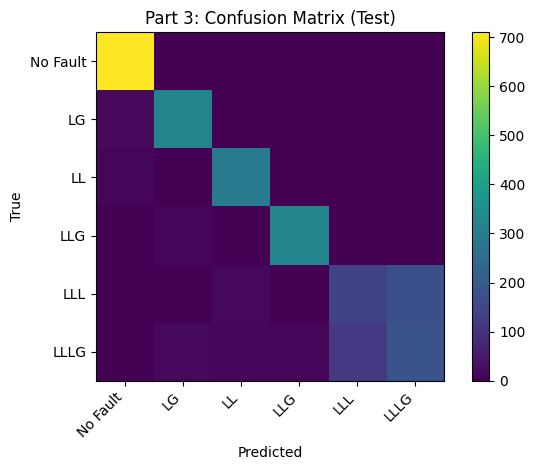

In [23]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: Part 2 is the best formulation for this dataset. Part 1 is the second best, while part 3 is the worst. For the type of data (4 bit output), it trains each one seperately which is the best approach. Part 2 has the highest Macro F1 score of 0.9369, compared to 0.9273 (Part 1) and 0.7834 (Part 3). Since it matches the data structure it works the best while regression is not probabilistic and multi class imposes incorrect constraints.

- Q2: This suggests that models without structural constraints (Parts 1 and 2) can produce invalid 4-bit combinations because each bit is predicted independently. Since the model does not enforce which global patterns are valid, any prediction errors can result in combinations that do not correspond to real fault types. In contrast, Part 3 restricts predictions to predefined classes, ensuring that only valid fault patterns are produced.

- Q3: For Part 1: 0110 (IC), 0111 (LLL), 1011 (LLG), 1001 (LG).

  For Part 2: 0110 (IC), 1001(LG),1011(LLG), 0111 (LLL), 1111(LLLG).
  
  For Part 3: LLL and LLLG.

  LLG and LLL seem to be the hardest to predict because all three confusion matrices show that they had false predictions. Parts 1 and 2 also had more false predictions for some other faults and invalid combinations. No fault was not difficult to predict, that was not falsely predicted.  *IC - Invalid Combo

## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [27]:
# 0 = No Fault
# 1 = Fault (anything else)

#Create two new datasets to be one without fault and the other with every type of faults.

y_fault_binary_train = (y_fault_train != 0).astype(np.int64)
y_fault_binary_test  = (y_fault_test  != 0).astype(np.int64)


In [25]:
# Convert them into torch tensors.
ytr_bin = torch.from_numpy(y_fault_binary_train.astype(np.float32))
yte_bin = torch.from_numpy(y_fault_binary_test.astype(np.float32))

In [28]:
# Create new torch loader.

Xtr_bin = torch.from_numpy(X_train_s3)
Xte_bin = torch.from_numpy(X_test_s3)

train_loader_bin = DataLoader(
    TensorDataset(Xtr_bin, ytr_bin),
    batch_size=BATCH_SIZE,
    shuffle=True
)


In [30]:
# Create model like Part 2 (best performance).

class DNN_Binary(nn.Module):
    def __init__(self, input_dim=6, h1=16, h2=8, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, 1)  # single logit
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


In [32]:
# Initialize model, loss function and optimizer.
model = DNN_Binary()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

In [40]:
# Training Loop
def train_part2(model, loader, epochs=EPOCHS):
    model.train()

    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float()

            optimizer.zero_grad()

            logits = model(xb)
            loss = loss_fn(logits, yb)

            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        avg_loss = total / n

        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep:4d} | Train BCE: {avg_loss:.6f}")

@torch.no_grad()
def predict_bits_bin(model, X_tensor, threshold=0.5):
    model.eval()

    X_t = X_tensor.to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).int().cpu().numpy()

    return preds

#Training model.
train_part2(model, train_loader_bin)


Epoch    1 | Train BCE: 0.024041
Epoch  500 | Train BCE: 0.023320
Epoch 1000 | Train BCE: 0.025428


=== Train ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1655
           1       1.00      0.99      1.00      3847

    accuracy                           1.00      5502
   macro avg       0.99      1.00      1.00      5502
weighted avg       1.00      1.00      1.00      5502

=== Test ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       710
           1       1.00      0.99      1.00      1649

    accuracy                           1.00      2359
   macro avg       0.99      1.00      1.00      2359
weighted avg       1.00      1.00      1.00      2359

Confusion Matrix (Test):


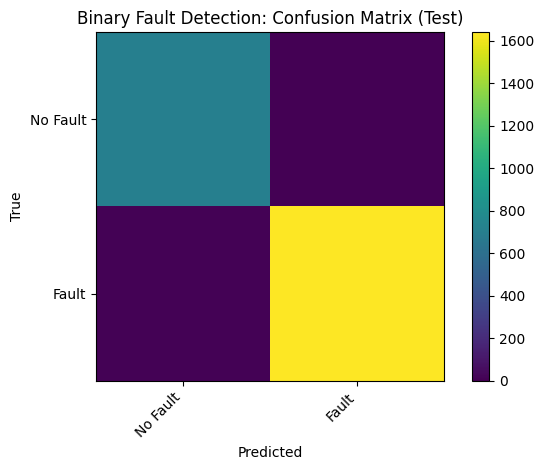

[[ 710    0]
 [   9 1640]]


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

#Print evaluation metrics (classification report and confusion matrix.)
print("=== Train ===")
print(classification_report(y_fault_binary_train, pred_bits_train_))

print("=== Test ===")
print(classification_report(y_fault_binary_test, pred_bits_test_))

print("Confusion Matrix (Test):")
BINARY_NAMES = ["No Fault", "Fault"]
cm_te = confusion_matrix(
    y_fault_binary_test,
    pred_bits_test_,
    labels=[0, 1]
)
plot_cm(cm_te, 'Binary Fault Detection: Confusion Matrix (Test)', BINARY_NAMES)
print(confusion_matrix(y_fault_binary_test, pred_bits_test_))
